In [1]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u
from matplotlib import cm
import time

import healpy as hp
import pandas as pd
from sklearn.neighbors import KDTree

In [2]:
# -------------------------------------------------------------------------------
# plotting settings
# -------------------------------------------------------------------------------

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple", "pale red"]
colors = sns.xkcd_palette(colors)
#colors = sns.color_palette("Blues")

matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)
fsize = 18

colors_cont = ["black", "grey", "light grey"] 
colors_cont = sns.xkcd_palette(colors_cont)

np.random.seed(40)

## Read in data

In [3]:
tab_gaia = Table.read('../data/gaia_wise_panstarrs_tmass.fits.gz', format='fits')
print('Total number of Gaia quasars:', len(tab_gaia))

Total number of Gaia quasars: 6649162


In [4]:
tab_gaia.columns

<TableColumns names=('ra','dec','redshift_qsoc','l','b','source_id','parallax','parallax_error','pmra','pmra_error','pmdec','pmdec_error','astrometric_excess_noise','visibility_periods_used','ipd_frac_multi_peak','ruwe','phot_g_n_obs','phot_g_mean_flux','phot_g_mean_flux_error','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','phot_bp_rp_excess_factor','in_qso_candidates','gaia_crf_source','vari_best_class_name','vari_best_class_score','fractional_variability_g','qso_variability','non_qso_variability','vari_agn_membership_score','classprob_dsc_combmod_quasar','classprob_dsc_combmod_galaxy','classlabel_dsc','classlabel_dsc_joint','classlabel_oa','redshift_qsoc_lower','redshift_qsoc_upper','zscore_qsoc','flags_qsoc','n_transits','intensity_quasar','intensity_quasar_error','host_galaxy_detected','intensity_hostgalaxy','intensity_hostgalaxy_error','radius_hostgalaxy','radius_hostgalaxy_error','host_galaxy_flag','source_selection_flags','allwise_oid','designation','w1mpro','w2mpro','

In [5]:
tab_sdss = Table.read('../data/SDSS_DR16Q_v4.fits', format='fits') 
print('Total number of SDSS quasars:', len(tab_sdss))

Total number of SDSS quasars: 750414


In [6]:
tab_sdss.columns

<TableColumns names=('SDSS_NAME','RA','DEC','PLATE','MJD','FIBERID','AUTOCLASS_PQN','AUTOCLASS_DR14Q','IS_QSO_QN','Z_QN','RANDOM_SELECT','Z_10K','Z_CONF_10K','PIPE_CORR_10K','IS_QSO_10K','THING_ID','Z_VI','Z_CONF','CLASS_PERSON','Z_DR12Q','IS_QSO_DR12Q','Z_DR7Q_SCH','IS_QSO_DR7Q','Z_DR6Q_HW','Z_DR7Q_HW','IS_QSO_FINAL','Z','SOURCE_Z','Z_PIPE','ZWARNING','OBJID','Z_PCA','ZWARN_PCA','DELTACHI2_PCA','Z_HALPHA','ZWARN_HALPHA','DELTACHI2_HALPHA','Z_HBETA','ZWARN_HBETA','DELTACHI2_HBETA','Z_MGII','ZWARN_MGII','DELTACHI2_MGII','Z_CIII','ZWARN_CIII','DELTACHI2_CIII','Z_CIV','ZWARN_CIV','DELTACHI2_CIV','Z_LYA','ZWARN_LYA','DELTACHI2_LYA','Z_LYAWG','Z_DLA','NHI_DLA','CONF_DLA','BAL_PROB','BI_CIV','ERR_BI_CIV','AI_CIV','ERR_AI_CIV','BI_SIIV','ERR_BI_SIIV','AI_SIIV','ERR_AI_SIIV','BOSS_TARGET1','EBOSS_TARGET0','EBOSS_TARGET1','EBOSS_TARGET2','ANCILLARY_TARGET1','ANCILLARY_TARGET2','NSPEC_SDSS','NSPEC_BOSS','NSPEC','PLATE_DUPLICATE','MJD_DUPLICATE','FIBERID_DUPLICATE','SPECTRO_DUPLICATE','SKYVERSION

Include only SDSS quasars with z>0.01 (this removes zeros and nans, and maybe a few others)

In [7]:
z_min = 0.01
idx_sdssgood = tab_sdss['Z'] > z_min
tab_sdss = tab_sdss[idx_sdssgood]
print(f'Number of SDSS quasars with: z > {z_min}: {len(tab_sdss)}')

Number of SDSS quasars with: z > 0.01: 750397


Cross-match SDSS and Gaia

In [8]:
coords_sdss = SkyCoord(ra=tab_sdss['RA']*u.degree, dec=tab_sdss['DEC']*u.degree, frame='icrs')    
coords_gaia = SkyCoord(ra=tab_gaia['ra'], dec=tab_gaia['dec'], frame='icrs') 
cross_sdss_gaia = coords_gaia.search_around_sky(coords_sdss, 1*u.arcsec) # Hogg thinks this is idiotic

Make new table, tab_xmatch, with only gaia objects with SDSS match

In [9]:
tab_xmatch = tab_gaia[cross_sdss_gaia[1]]
tab_sdss = tab_sdss[cross_sdss_gaia[0]]
print(f'Number of Gaia quasars with SDSS match (with z min cut): {len(tab_xmatch)}')

Number of Gaia quasars with SDSS match (with z min cut): 407236


In [10]:
tab_xmatch.add_column(tab_sdss['Z'], name='redshift_sdss')

## Dust map

Load in Schlegel, Finkbeiner & Davis (1998) dust map from the dustmaps package

In [11]:
# only do this the first time!
fetch_map = False
if fetch_map:
    from dustmaps.config import config
    config['data_dir'] = '/Users/ksf/code/nyu/research/gaia-quasars-lss/data/dustmaps'

    import dustmaps
    import dustmaps.sfd
    dustmaps.sfd.fetch()

In [12]:
from dustmaps.sfd import SFDQuery
sfd = SFDQuery()

Get reddening E(B-V) from dust map at each of the cross-matched quasars:

E(B-V): https://astronomy.swin.edu.au/cosmos/i/interstellar+reddening

In [13]:
coords = SkyCoord(ra=tab_xmatch['ra'], dec=tab_xmatch['dec'], frame='icrs') 

In [14]:
ebv = sfd(coords)

In [15]:
tab_xmatch.add_column(ebv, name='ebv')

Text(0, 0.5, 'number per bin')

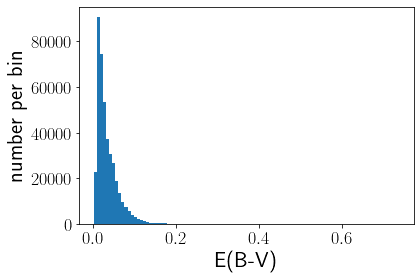

In [16]:
plt.hist(ebv, bins=100)
plt.xlabel('E(B-V)')
plt.ylabel('number per bin')

Plot extinction for SDSS matched quasars:

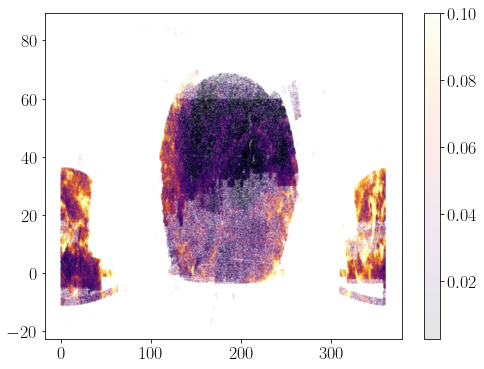

In [17]:
plt.figure(figsize=(8,6))
plt.scatter(tab_xmatch['ra'], tab_xmatch['dec'], c=ebv, s=0.1, alpha=0.1, cmap='inferno', vmax=0.1)
plt.colorbar()

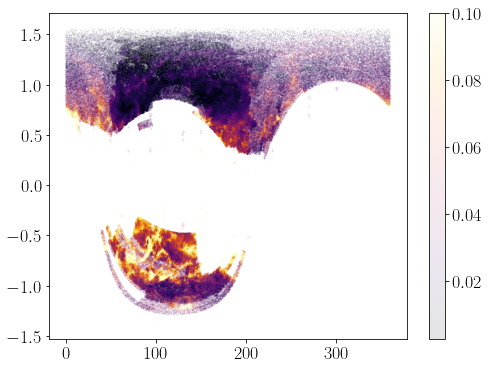

In [18]:
plt.figure(figsize=(8,6))
b = tab_xmatch["b"] * np.pi/180
plt.scatter(tab_xmatch['l'], b, c=ebv, s=0.1, alpha=0.1, cmap='inferno', vmax=0.1)
plt.colorbar()

Get extinction for full Gaia sample (will be used for application of method):

In [19]:
ebv_gaia = sfd(coords_gaia)

In [20]:
tab_gaia.add_column(ebv_gaia, name='ebv')

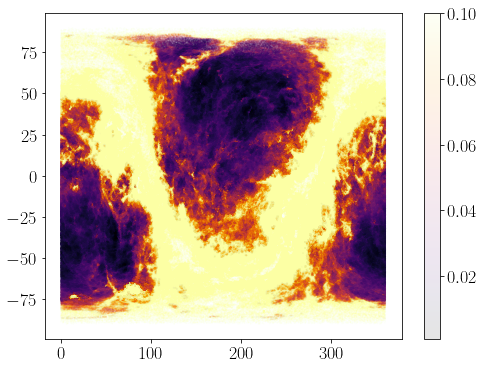

In [21]:
plt.figure(figsize=(8,6))
plt.scatter(tab_gaia['ra'], tab_gaia['dec'], c=ebv_gaia, s=0.1, alpha=0.1, cmap='inferno', vmax=0.1)
plt.colorbar()

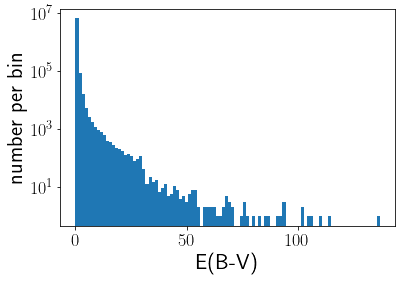

In [22]:
plt.hist(ebv_gaia, bins=100)
plt.xlabel('E(B-V)')
plt.ylabel('number per bin')
plt.yscale('log')

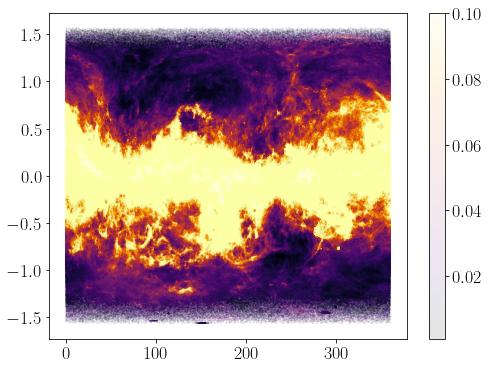

In [23]:
plt.figure(figsize=(8,6))
b = tab_gaia["b"] * np.pi/180
plt.scatter(tab_gaia['l'], b, c=ebv_gaia, s=0.1, alpha=0.1, cmap='inferno', vmax=0.1)
plt.colorbar()

## Color features

Colors, all Gaia:

In [24]:
# ALL GAIA
# wise
w1_w2_gaia = np.array(tab_gaia['w1mpro']) - np.array(tab_gaia['w2mpro'])
g_w1_gaia = np.array(tab_gaia['phot_g_mean_mag']) - np.array(tab_gaia['w1mpro']) # think was error before, w2 instead of w1

Colors, cross-match:

In [25]:
# SDSS cross-match
# gaia
bp_g = np.array(tab_xmatch['phot_bp_mean_mag'] - tab_xmatch['phot_g_mean_mag'])
g_rp = np.array(tab_xmatch['phot_g_mean_mag']) - np.array(tab_xmatch['phot_rp_mean_mag'])
bp_rp = np.array(tab_xmatch['phot_bp_mean_mag']) - np.array(tab_xmatch['phot_rp_mean_mag'])

# wise
w1_w2 = np.array(tab_xmatch['w1mpro']) - np.array(tab_xmatch['w2mpro'])
g_w1 = np.array(tab_xmatch['phot_g_mean_mag']) - np.array(tab_xmatch['w1mpro']) # think was error before, w2 instead of w1

Band values, cross-match:

In [26]:
# SDSS cross-match
# gaia
g = np.array(tab_xmatch['phot_bp_mean_mag'])
rp = np.array(tab_xmatch['phot_rp_mean_mag'])
bp = np.array(tab_xmatch['phot_bp_mean_mag'])

# wise
w1 = np.array(tab_xmatch['w1mpro'])
w2 = np.array(tab_xmatch['w2mpro'])

Check out color space of quasars, & choose cuts to isolate them:

In [27]:
w1_w2_min = 0.1
g_w1_min = 2.2

Text(0, 0.5, 'W1-W2')

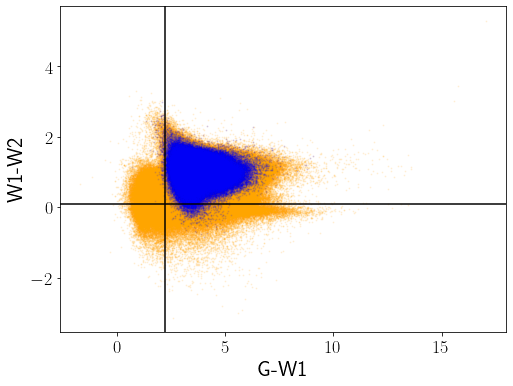

In [28]:
plt.figure(figsize=(8,6))
plt.scatter(g_w1_gaia, w1_w2_gaia, s=1, alpha=0.1, color='orange')
plt.scatter(g_w1, w1_w2, s=1, alpha=0.1, color='blue')
plt.axhline(w1_w2_min,color='k')
plt.axvline(g_w1_min,color='k')
plt.xlabel('G-W1')
plt.ylabel('W1-W2')

In [29]:
index = (w1_w2 > w1_w2_min) & (g_w1 > g_w1_min)
print('Fraction of SDSS quasars that make color cuts:', np.sum(index) / np.sum(np.isfinite(w1_w2)))

Fraction of SDSS quasars that make color cuts: 0.9954064495971255


Color cut + magnitude cut

In [30]:
idx_qso = (w1_w2 > 0.1) & (g_w1 > 2.2)   
idx_gmag = (tab_xmatch['phot_g_mean_mag'] < 20)
idx_photoz = idx_qso & idx_gmag                  
print('Fraction of Gaia-SDSS cross-matched quasars that make cuts:', np.sum(idx_photoz)/len(tab_xmatch))

Fraction of Gaia-SDSS cross-matched quasars that make cuts: 0.4173108467817187


## Features

In [31]:
def construct_X(table, features='colors', rescale_X=False, return_idx_good=False):
    assert features in ['colors', 'magnitudes'], "Feature mode not recognized!"
    
    redshift_qsoc = np.array(table['redshift_qsoc'])
    ebv = np.array(table['ebv'])    
    
    g = np.array(table['phot_g_mean_mag'])
    rp = np.array(table['phot_rp_mean_mag'])
    bp = np.array(table['phot_bp_mean_mag'])

    # wise
    w1 = np.array(table['w1mpro'])
    w2 = np.array(table['w2mpro'])

    if features=='colors':
        X = np.vstack([redshift_qsoc, ebv,
                   bp-g, g-rp, bp-rp, w1-w2, g-w1, 
                   ]).T

    if features=='magnitudes':
        X = np.vstack([redshift_qsoc, ebv,
                   g, bp, rp, w1, w2, 
                   ]).T
    
    idx_good = np.all(np.isfinite(X), axis=1)
    X = X[idx_good]

    # my attempts at rescaling make it worse!! why??
    if rescale_X:
        stds = np.std(X[:,1:], axis=0)
        print(stds)
        X[:,1:] /= stds
    
    print(np.std(X, axis=0))
    print(X.shape)
    if return_idx_good:
        return X, idx_good
    
    return X

In [32]:
def construct_Y(table, idx_to_use=None):
    Y = table['redshift_sdss']
    if idx_to_use is not None:
        Y = Y[idx_to_use]
    print(Y.shape)
    return Y

In [33]:
X, idx_good = construct_X(tab_xmatch[idx_photoz], features='colors', return_idx_good=True, rescale_X=False)
Y = construct_Y(tab_xmatch[idx_photoz], idx_to_use=idx_good)
assert X.shape[0]==Y.shape[0], 'X and Y must have same number of objects!'

[1.00459495 0.02539967 0.12619737 0.16497785 0.20241437 0.22895746
 0.63449554]
(168063, 7)
(168063,)


## Perform cross-validation

Set up samples (loo = leave one out)

In [34]:
n_samples = 8
np.random.seed(17)
i_samples = np.arange(n_samples)
loo_samples = np.random.choice(i_samples, replace=True, size=X.shape[0])

For now, just choosing one of the samples

In [35]:
# guessing 11 for now - hogg's intuition
K = 11

In [40]:
redshift_qsoc_photoz = tab_xmatch['redshift_qsoc'][idx_photoz]

In [41]:
z_err_close = 0.2
frac_recovered_baseline = np.sum(np.abs(Y - redshift_qsoc_photoz[idx_good]) < z_err_close) / len(Y)
print(rf"Fraction of QSOC redshifts with dz < {z_err_close}: {frac_recovered_baseline:.3f}")

Fraction of QSOC redshifts with dz < 0.2: 0.823


In [42]:
Y_hat = np.empty(X.shape[0])
sigma_z = np.empty(X.shape[0])

for i_sample in i_samples:
    print(f"Querying loo_sample={i_sample}")
    idx_train = loo_samples != i_sample
    idx_valid = loo_samples == i_sample
    X_train, Y_train = X[idx_train], Y[idx_train]
    X_valid, Y_valid = X[idx_valid], Y[idx_valid]
    
    # construct tree
    tree = KDTree(X_train)
    
    # query neighbors
    dists, inds = tree.query(X_valid, k=K)
    
    # Choose our best photoz estimate to be the median SDSS (training) redshift 
    # of the nearest neighbors; also get lower and upper percentiles
    low_z_valid, Y_hat_valid, up_z_valid = np.percentile(Y_train[inds], (2.5, 50, 97.5), axis=1)
    sigma_z_valid = (up_z_valid - low_z_valid)/4
    
    Y_hat[idx_valid] = Y_hat_valid
    sigma_z[idx_valid] = sigma_z_valid
    
    frac_recovered = np.sum(np.abs(Y_valid - Y_hat_valid) < z_err_close) / len(Y_valid)
    print(rf"Fraction of photozs with dz < {z_err_close}: {frac_recovered:.3f}")

Querying loo_sample=0
Fraction of photozs with dz < 0.2: 0.907
Querying loo_sample=1
Fraction of photozs with dz < 0.2: 0.899
Querying loo_sample=2
Fraction of photozs with dz < 0.2: 0.907
Querying loo_sample=3
Fraction of photozs with dz < 0.2: 0.904
Querying loo_sample=4
Fraction of photozs with dz < 0.2: 0.903
Querying loo_sample=5
Fraction of photozs with dz < 0.2: 0.906
Querying loo_sample=6
Fraction of photozs with dz < 0.2: 0.907
Querying loo_sample=7
Fraction of photozs with dz < 0.2: 0.904


Plot results

Text(0, 0.5, 'Number per bin')

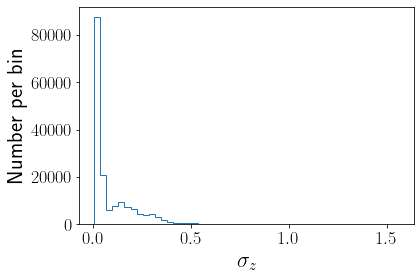

In [43]:
plt.hist(sigma_z, histtype='step', bins=50)
plt.xlabel(r'$\sigma_z$')
plt.ylabel(r'Number per bin')

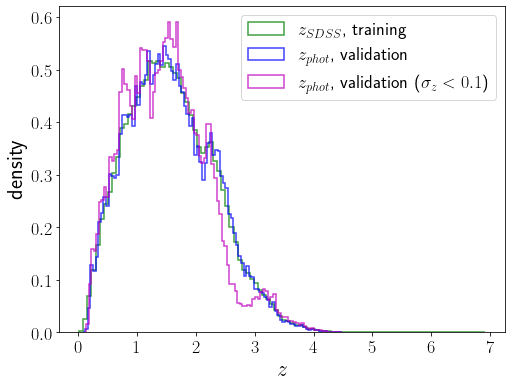

In [44]:
alpha = 0.75
lw = 1.5
density = True
histtype='step'

plt.figure(figsize=(8,6))
_ = plt.hist(Y_train, bins=100, alpha=alpha, color='g', lw=lw,
             density=density, histtype=histtype, label=r'$z_{SDSS}$, training')
_ = plt.hist(Y_hat, bins=100, alpha=alpha, color='b', lw=lw,
             density=density, histtype=histtype, label=r'$z_{phot}$, validation')
_ = plt.hist(Y_hat[sigma_z < 0.1], bins=100, alpha=alpha, color='m', lw=lw, 
             density=density, histtype=histtype, label=r'$z_{phot}$, validation ($\sigma_z < 0.1$)')
plt.xlabel(r'$z$')
plt.ylabel('density')
plt.legend()

Text(0, 0.5, 'Gaia QSOC redshift')

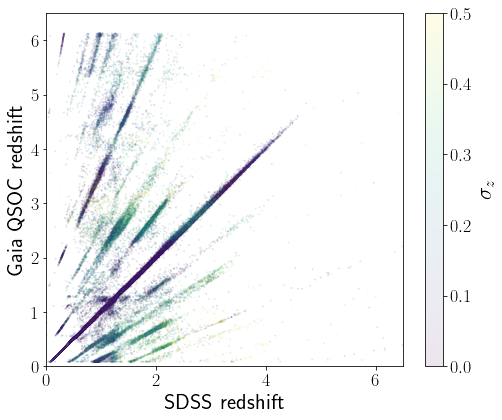

In [45]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
sc = ax.scatter(Y, redshift_qsoc_photoz[idx_good], s = 1, c=sigma_z, vmin=0, vmax=0.5, alpha=0.1)
cbar = plt.colorbar(sc, label=r'$\sigma_z$')
ax.set_xlim(0, 6.5)
ax.set_ylim(0, 6.5)
plt.xlabel('SDSS redshift')
plt.ylabel('Gaia QSOC redshift')

Text(0, 0.5, 'redshift estimate (Gaia QSOC + photometry + SFD)')

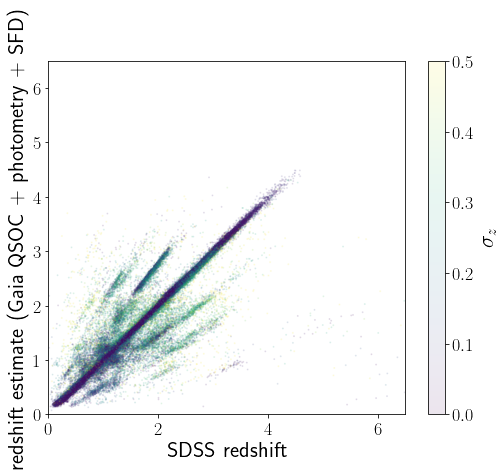

In [46]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
sc = ax.scatter(Y, Y_hat, s = 1, c=sigma_z, vmin=0, vmax=0.5, alpha=0.1)
cbar = plt.colorbar(sc, label=r'$\sigma_z$')
ax.set_xlim(0, 6.5)
ax.set_ylim(0, 6.5)
plt.xlabel('SDSS redshift')
plt.ylabel('redshift estimate (Gaia QSOC + photometry + SFD)')

Text(0, 0.5, 'redshift estimate (Gaia QSOC + photometry + SFD)')

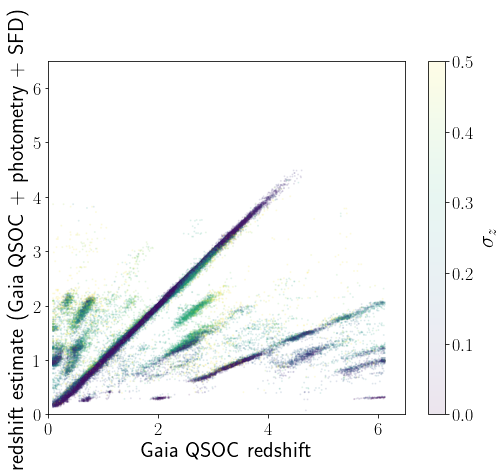

In [47]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
sc = ax.scatter(redshift_qsoc_photoz[idx_good], Y_hat, s = 1, c=sigma_z, vmin=0, vmax=0.5, alpha=0.1)
cbar = plt.colorbar(sc, label=r'$\sigma_z$')
ax.set_xlim(0, 6.5)
ax.set_ylim(0, 6.5)
plt.xlabel('Gaia QSOC redshift')
plt.ylabel('redshift estimate (Gaia QSOC + photometry + SFD)')

Check metrics

In [48]:
z_err_close = 0.2
frac_recovered_baseline = np.sum(np.abs(Y - redshift_qsoc_photoz[idx_good]) < z_err_close) / len(Y)
frac_recovered = np.sum(np.abs(Y - Y_hat) < z_err_close) / len(Y)
print(frac_recovered_baseline)
print(frac_recovered)

0.822560587398773
0.9044822477285304


In [49]:
percentile_vals = [50, 80, 90, 95, 98]
percentiles = np.percentile(np.abs(Y - Y_hat), percentile_vals)
print(f'The {percentile_vals} percentiles of redshift errors are:')
print([float(f"{p:.3f}") for p in percentiles])

The [50, 80, 90, 95, 98] percentiles of redshift errors are:
[0.018, 0.049, 0.174, 0.576, 0.856]


Text(0, 0.5, 'number per bin')

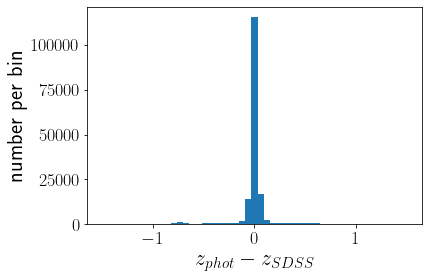

In [50]:
bins = np.linspace(-1.5, 1.5, 50)
plt.hist(Y - Y_hat, bins=bins)
plt.xlabel(r'$z_{phot} - z_{SDSS}$')
plt.ylabel('number per bin')

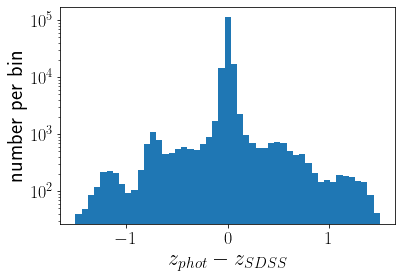

In [51]:
bins = np.linspace(-1.5, 1.5, 50)
plt.hist(Y - Y_hat, bins=bins)
plt.xlabel(r'$z_{phot} - z_{SDSS}$')
plt.ylabel('number per bin')
plt.yscale('log')

# Apply photozs to whole sample

In [52]:
idx_gaia_qso = (w1_w2_gaia > 0.1) & (g_w1_gaia > 2.2)  
idx_gaia_gmag = (tab_gaia['phot_g_mean_mag'] < 20.2)  
print(np.sum(idx_gaia_qso)/len(tab_gaia))
print(np.sum(idx_gaia_gmag)/len(tab_gaia))

0.24121972062043306
0.38286298333534363


In [53]:
idx_gaia_photoz = idx_gaia_qso & idx_gaia_gmag   
print(np.sum(idx_gaia_photoz), len(tab_gaia))

875927 6649162


In [54]:
X_gaia_photoz, idx_good_gaia_photoz = construct_X(tab_gaia[idx_gaia_photoz], features='colors', return_idx_good=True)

[1.10556643 0.08628752 0.16266775 0.24032293 0.22630313 0.25653638
 0.71574352]
(816492, 7)


In [55]:
tree = KDTree(X)

In [56]:
dists_gaia_photoz, inds_gaia_photoz = tree.query(X_gaia_photoz, k=K)

In [57]:
low_z_gaia_photoz, Y_hat_gaia_photoz, up_z_gaia_photoz = np.percentile(Y[inds_gaia_photoz], (2.5, 50, 97.5), axis=1)
sigma_z_gaia_photoz = (up_z_gaia_photoz - low_z_gaia_photoz)/4

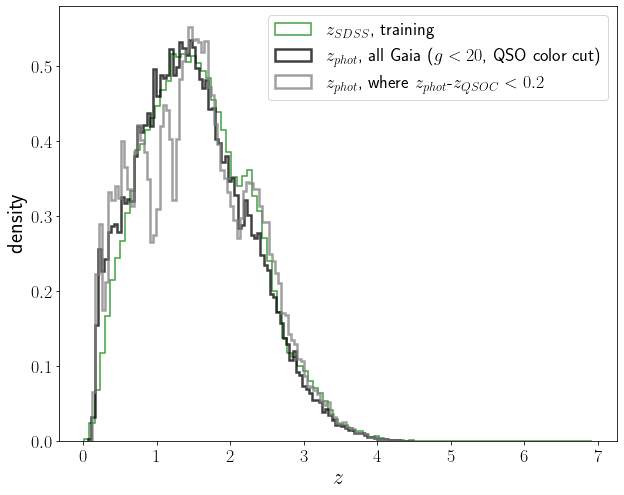

In [58]:
alpha = 0.75
lw = 1.5
density = True
histtype='step'

# should i take from photoz or qsoc? on same line so v similar
Y_agree_gaia_photoz = Y_hat_gaia_photoz[np.abs(Y_hat_gaia_photoz - X_gaia_photoz[:,0]) < z_err_close]

plt.figure(figsize=(10,8))
_ = plt.hist(Y_train, bins=100, alpha=alpha, color='g', lw=lw,
             density=density, histtype=histtype, label=r'$z_{SDSS}$, training')
_ = plt.hist(Y_hat_gaia_photoz, bins=100, alpha=alpha, color='k', lw=2.5, 
             density=density, histtype=histtype, label=r'$z_{phot}$, all Gaia ($g < 20$, QSO color cut)')
_ = plt.hist(Y_agree_gaia_photoz, bins=100, alpha=alpha, color='grey', lw=2.5, 
             density=density, histtype=histtype, label=rf'$z_{{phot}}$, where $z_{{phot}}$-$z_{{QSOC}} < {z_err_close}$')
plt.xlabel(r'$z$')
plt.ylabel('density')
plt.legend()

# Healpix 

Generate pixels

In [59]:
# healpix grids have npix = 12*nside^2. want n_qso_per_pix=10-20 QS0s per pixel, so if we have n_qso quasars, we want:
# nside = sqrt((n_qso/n_qso_per_pix)/12)
n_qso = len(tab_gaia[idx_gaia_photoz])
n_qso_per_pix = 15
NSIDE = round(np.sqrt((n_qso/n_qso_per_pix)/12))
print(NSIDE)

70


In [60]:
print("Approximate resolution at NSIDE {} is {:.2} deg".format(NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60))

Approximate resolution at NSIDE 70 is 0.84 deg


In [61]:
NPIX = hp.nside2npix(NSIDE)
print(NPIX)

58800


In [62]:
pixel_arr = np.arange(NPIX)

Apply to data

In [63]:
pixel_indices = hp.ang2pix(NSIDE, tab_gaia['ra'][idx_gaia_photoz], tab_gaia['dec'][idx_gaia_photoz], lonlat=True)

In [64]:
av_gaia_photoz = 3.1 * tab_gaia['ebv'][idx_gaia_photoz]
len(av_gaia_photoz)

875927

In [65]:
# copied from https://stackoverflow.com/questions/49372918/group-numpy-into-multiple-sub-arrays-using-an-array-of-values
def groupby(values, group_indices):
    # Get argsort indices, to be used to sort a and b in the next steps
    sidx = group_indices.argsort(kind='mergesort')
    values_sorted = values[sidx]
    group_indices_sorted = group_indices[sidx]

    # Get the group limit indices (start, stop of groups)
    cut_idx = np.flatnonzero(np.r_[True,group_indices_sorted[1:] != group_indices_sorted[:-1],True])

    # Split input array with those start, stop ones
    values_grouped = [values_sorted[i:j] for i,j in zip(cut_idx[:-1],cut_idx[1:])]
    return values_grouped, list(set(group_indices_sorted))

In [66]:
# this is too slow, use groupby
# av_mean = [np.mean(av_gaia_gmag[np.where(pixel_idx == pixel_indices)]) for pixel_idx in pixel_indices]
av_grouped, pixel_indices_sorted = groupby(av_gaia_photoz, pixel_indices)

Check number per pixel

In [67]:
n_per_pixel = np.array([len(avs) for avs in av_grouped])

Text(0, 0.5, 'number per (histogram) bin')

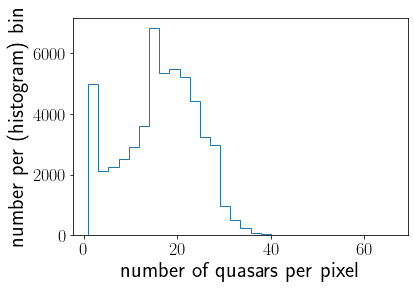

In [68]:
plt.hist(n_per_pixel, bins=30, histtype='step')
plt.xlabel('number of quasars per pixel')
plt.ylabel('number per (histogram) bin')

In [69]:
av_means = np.array([np.mean(avs) for avs in av_grouped])

In [70]:
map_av = np.zeros(NPIX)
map_av[pixel_indices_sorted] = av_means

In [71]:
pixels_nodata = list(set(pixel_arr) - set(pixel_indices_sorted))
map_av[pixels_nodata] = np.nan

0.0 180.0 -180.0 180.0


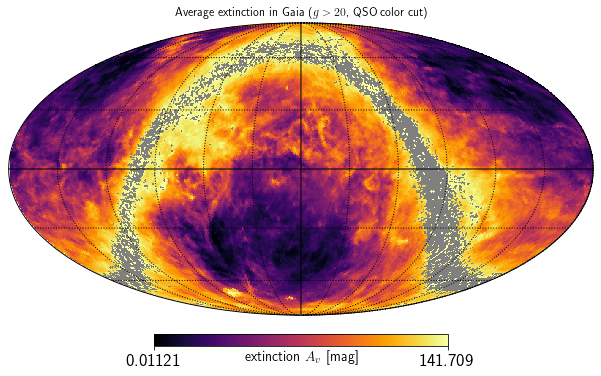

In [72]:
hp.mollview(
    map_av,
    title=r"Average extinction in Gaia ($g > 20$, QSO color cut)",
    unit=r"extinction $A_v$ [mag]",
    norm="hist",
    cmap='inferno',
    #min=-1,
    #max=1,
)
hp.graticule()

0.0 180.0 -180.0 180.0


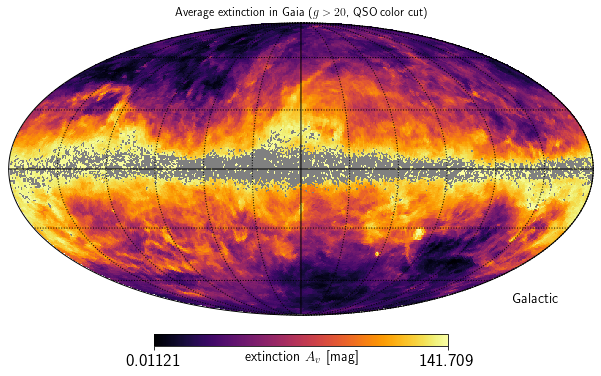

In [73]:
hp.mollview(
    map_av,
    title=r"Average extinction in Gaia ($g > 20$, QSO color cut)",
    unit=r"extinction $A_v$ [mag]",
    norm="hist",
    cmap='inferno',
    coord=['C', 'G']
    #min=-1,
    #max=1,
)
hp.graticule()

In [74]:
map_nqso = np.zeros(NPIX)
map_nqso[pixel_indices_sorted] = n_per_pixel

0.0 180.0 -180.0 180.0


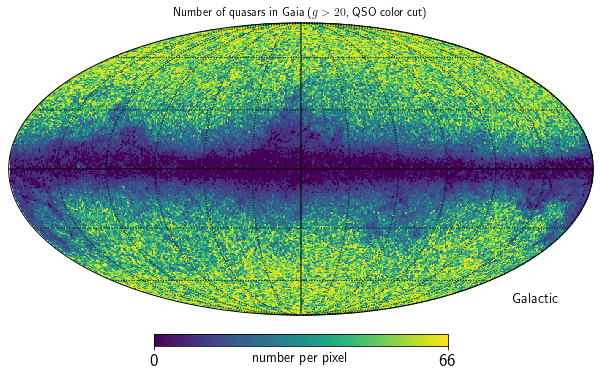

In [75]:
hp.mollview(
    map_nqso,
    title=r"Number of quasars in Gaia ($g > 20$, QSO color cut)",
    unit=r"number per pixel",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G']
    #min=-1,
    #max=1,
)
hp.graticule()

Random catalog

In [76]:
N_rand = n_qso*10
us = np.random.uniform(size=N_rand)
vs = np.random.uniform(size=N_rand)
theta_rand = 2 * np.pi * us
phi_rand = np.arccos(2*vs-1)

In [77]:
ra_rand = (theta_rand * 180/np.pi) * u.deg
dec_rand = (phi_rand * 180/np.pi - 90) * u.deg

In [78]:
coords_rand = SkyCoord(ra=ra_rand, dec=dec_rand, frame='icrs') 

In [79]:
ebv_rand = sfd(coords_rand)

In [80]:
av_rand = 3.1*ebv_rand

In [81]:
pixel_indices_rand = hp.ang2pix(NSIDE, ra_rand.value, dec_rand.value, lonlat=True)

In [82]:
av_grouped_rand, pixel_indices_sorted_rand = groupby(av_rand, pixel_indices_rand)

In [83]:
av_means_rand = np.array([np.mean(avs) for avs in av_grouped_rand])

In [84]:
map_av_rand = np.zeros(hp.nside2npix(NSIDE))
map_av_rand[pixel_indices_sorted_rand] = av_means_rand

In [85]:
# pixels_nodata = list(set(pixel_arr) - set(pixel_indices_sorted))
# map_av[pixels_nodata] = np.nan

0.0 180.0 -180.0 180.0


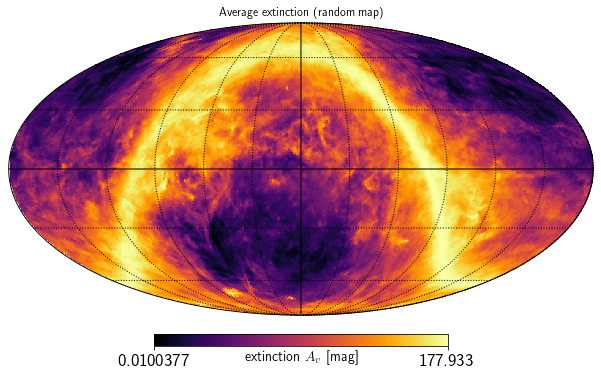

In [86]:
hp.mollview(
    map_av_rand,
    title=r"Average extinction (random map)",
    unit=r"extinction $A_v$ [mag]",
    norm="hist",
    cmap='inferno',
    #min=-1,
    #max=1,
)
hp.graticule()

0.0 180.0 -180.0 180.0


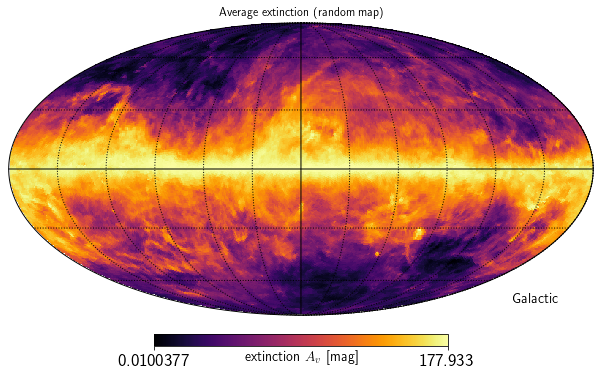

In [87]:
hp.mollview(
    map_av_rand,
    title=r"Average extinction (random map)",
    unit=r"extinction $A_v$ [mag]",
    norm="hist",
    cmap='inferno',
    coord=['C', 'G']
    #min=-1,
    #max=1,
)
hp.graticule()

0.0 180.0 -180.0 180.0


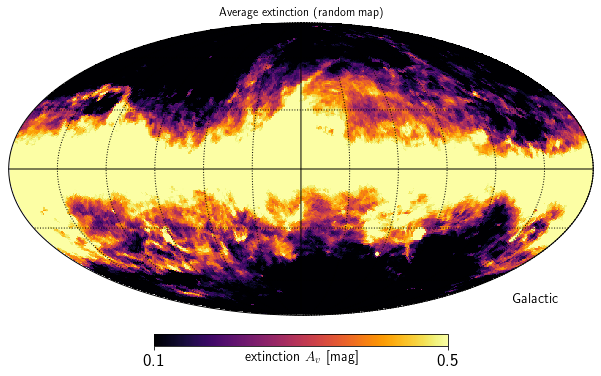

In [88]:
hp.mollview(
    map_av_rand,
    title=r"Average extinction (random map)",
    unit=r"extinction $A_v$ [mag]",
    norm="hist",
    cmap='inferno',
    coord=['C', 'G'],
    min=0.1,
    max=0.5,
)
hp.graticule()

In [89]:
len(n_per_pixel), len(av_means_rand)

(53805, 58800)

Text(0, 0.5, 'number of Gaia QSOs in pixel')

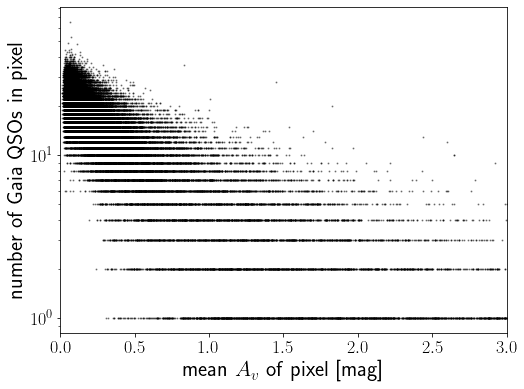

In [90]:
plt.figure(figsize=(8,6))
plt.scatter(map_av_rand, map_nqso, color='k', s=1, alpha=0.4)
#plt.xscale('log')
plt.yscale('log')
plt.xlim(0, 3)
plt.xlabel(f'mean $A_v$ of pixel [mag]')
plt.ylabel(f'number of Gaia QSOs in pixel')

Redshift distribution of Gaia quasars in quartiles of mean reddening

In [91]:
redshift_qsoc_gaia_photoz = tab_gaia['redshift_qsoc'][idx_gaia_photoz]

In [92]:
av_rand_gaia_photoz = np.array([map_av_rand[pixel_idx] for pixel_idx in pixel_indices])
len(av_rand_gaia_photoz)

875927

In [93]:
percentile_vals = [0, 25, 50, 75, 100]
percentiles = np.percentile(av_rand_gaia_photoz, percentile_vals)
print(percentiles)

[1.00377342e-02 7.06062466e-02 1.28882036e-01 2.40077242e-01
 6.22274017e+01]


218970
218981
218973
218979


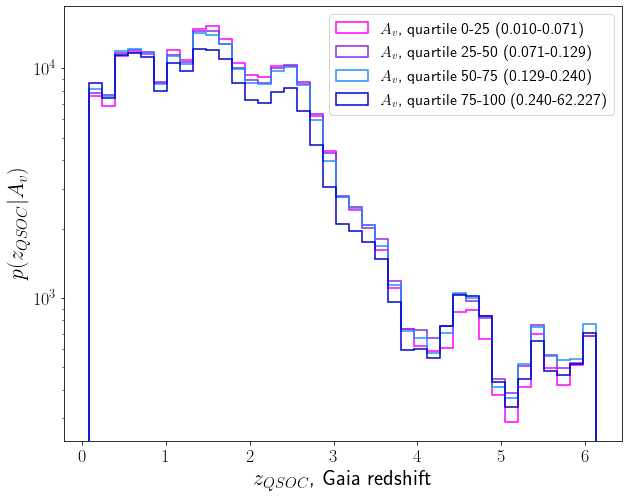

In [94]:
bins = np.linspace(np.min(redshift_qsoc_gaia_photoz), np.max(redshift_qsoc_gaia_photoz), 40)
labels = [rf'$A_v$, quartile {percentile_vals[i]}-{percentile_vals[i+1]}'
          f' ({percentiles[i]:.3f}-{percentiles[i+1]:.3f})' for i in range(len(percentile_vals)-1)]
colors = ['magenta', 'blueviolet', 'dodgerblue', 'mediumblue']

plt.figure(figsize=(10,8))
for i in range(len(percentiles)-1):
    z_with_av_in_bin = redshift_qsoc_gaia_photoz[(av_rand_gaia_photoz > percentiles[i]) &
                                                 (av_rand_gaia_photoz <= percentiles[i+1])]
    print(len(z_with_av_in_bin))
    plt.hist(z_with_av_in_bin, bins=bins, histtype='step', label=labels[i], color=colors[i], lw=1.5)
    
plt.xlabel(r'$z_{QSOC}$, Gaia redshift')
plt.ylabel(r'$p(z_{QSOC}|A_v)$')
plt.legend(fontsize=16)
plt.yscale('log')

For gaia photo-zs, need to redo percentiles because we cut out some QSOs that didn't have WISE colors:

In [95]:
percentile_vals = [0, 25, 50, 75, 100]
percentiles = np.percentile(av_rand_gaia_photoz[idx_good_gaia_photoz], percentile_vals)
print(percentiles)

[1.00377342e-02 6.89528584e-02 1.23623028e-01 2.23372832e-01
 4.43811150e+01]


204100
204132
204123
204113


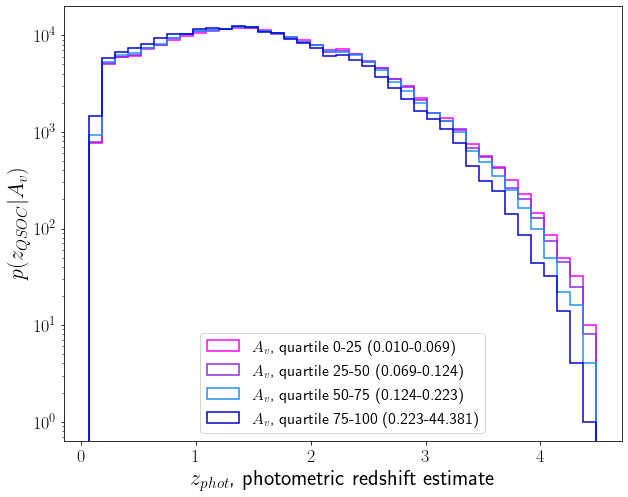

In [98]:
bins = np.linspace(np.min(Y_hat_gaia_photoz), np.max(Y_hat_gaia_photoz), 40)
labels = [rf'$A_v$, quartile {percentile_vals[i]}-{percentile_vals[i+1]}'
          f' ({percentiles[i]:.3f}-{percentiles[i+1]:.3f})' for i in range(len(percentile_vals)-1)]
colors = ['magenta', 'blueviolet', 'dodgerblue', 'mediumblue']

plt.figure(figsize=(10,8))
for i in range(len(percentiles)-1):
    z_with_av_in_bin = Y_hat_gaia_photoz[(av_rand_gaia_photoz[idx_good_gaia_photoz] > percentiles[i]) &
                                         (av_rand_gaia_photoz[idx_good_gaia_photoz] <= percentiles[i+1])]
    print(len(z_with_av_in_bin))
    plt.hist(z_with_av_in_bin, bins=bins, histtype='step', label=labels[i], color=colors[i], lw=1.5)
    
plt.xlabel(r'$z_{phot}$, photometric redshift estimate')
plt.ylabel(r'$p(z_{QSOC}|A_v)$')
plt.legend(fontsize=16, loc='lower center')
plt.yscale('log')

# Investigate number counts

Croom 2009

In [99]:
# from Croom+2009 (https://watermark.silverchair.com/mnras0399-1755.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAvkwggL1BgkqhkiG9w0BBwagggLmMIIC4gIBADCCAtsGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQM0bx1xrurbPjhw291AgEQgIICrA-TaVZLrM45-jMNX82T5C6ZjocrGEuFNjwP4S_dtJCmlUloEb1C8gYOpTCoP-amWMCMjmHLc10G68fr2b5JZbNzwW3pUlfb91KR1Wxj8VMDyNcpBwidgPpaFB27k8s1szlJNRMUwasEv1WJonFrkiXRcRqdfVkhPtdJMrK3WZXIa7qvP61AIvQ0PTytApdL5r4taph4sk7j0OF60tajDssCsye96vBgcxMppZkKSJn4OptOKh4W6rva7ixSYXpyg9sZ6ipwMd3NN1R_7zIYieXeyCrT0W11ObqO8MzHUO4Qkfu31vEro-sL6DC2iZkTmhc6CFTvFJrZtf142_c-2JvUr7em12vxwj9jUZfhMLxkmKAsSTDoOi4_GoJ795JaCWIm61tOoGYzYjamx2I0pMb1dz-5sR578tGCVhqEBFJcQEpBEa6G0IqjzJ8PvtP1Rcb35bmN-iK7lRQgce5GQghdxz7xDyyeRdSfx3kLZmCMbHNbKKRzbcGpsGv4TDcDuxZZq1iLN2jcN58uK8HHLdxkodHpTPQHewwXv0FFrFCTLx9LMNdEQ-RhIDXLNaMwZ_JCy6b3HtvT8S7O0fdMlkNQAO09BrMHPJWMKTN1SsssOGxe23ZLvIsvVRd43LjFgUr1sZxCJgyZEkVIlCuYW1ZwxE6JG35GzRYCMk_gTgZYF7_jVJoBYvIvkIsN90DgUa9i4ZIhHWaGFQypaLbh0FsYoaENxsrXxqQsaEPWfzm1Qs0c4NfNifbmYYXghuDQxJtB9raAjIL_h8AgGn-p5h7uel66sPpCojKmbyrnzFICu3O2R8sQl9R0Ry8a5HhQy6t0TafX9GX7vF9FXzt1fS5QdzjvtsdTx5VAsLunMDKWWorufdPouDP6oRbdSFavJ92OR7ruVuRxHlwdhA)
# using plot digitizer
mags_2slaq, counts_2slaq = np.loadtxt('../data/qso_counts_2SLAQ_croom2009.csv', delimiter=',', unpack=True)

SDSS

In [100]:
pixel_indices_sdss = hp.ang2pix(NSIDE, tab_sdss['RA'], tab_sdss['DEC'], lonlat=True)

In [101]:
# ra is just dummy to count 
ra_grouped_sdss, pixel_indices_sorted_sdss = groupby(tab_sdss['RA'], pixel_indices_sdss)
n_per_pixel_sdss = np.array([len(ras) for ras in ra_grouped_sdss])

In [102]:
map_nqso_sdss = np.zeros(NPIX)
map_nqso_sdss[pixel_indices_sorted_sdss] = n_per_pixel_sdss

In [103]:
n_pixels_with_qsos = len(pixel_indices_sorted_sdss)
area_sdss = n_pixels_with_qsos*hp.pixelfunc.nside2pixarea(NSIDE, degrees=True)
print(area_sdss)

11362.805448904668


NOTE: not doing magnitude cut here! should i be?? 

0.0 180.0 -180.0 180.0


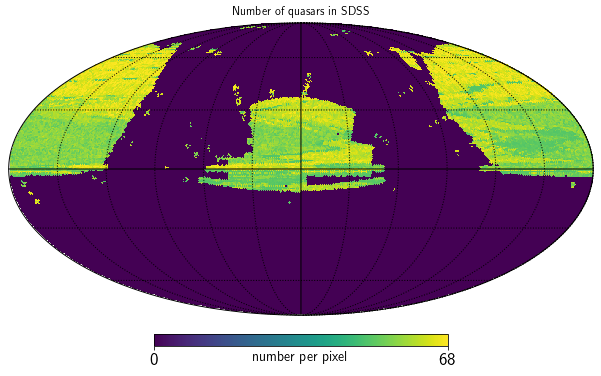

In [104]:
hp.mollview(
    map_nqso_sdss,
    title=r"Number of quasars in SDSS",
    unit=r"number per pixel",
    norm="hist",
    cmap='viridis',
    #coord=['C', 'G']
    #min=-1,
    #max=1,
)
hp.graticule()

In [105]:
g_sdss = tab_sdss['GAIA_G_MAG']
weights_sdss = np.full(len(g_sdss), 1/area_sdss)

All gaia quasars

NOTE: For Gaia area, i include only pixels where there are galaxies, like SDSS??

In [106]:
area_gaia = 4*np.pi*(360/(2*np.pi))**2
print(area_gaia)

41252.96124941928


In [107]:
g_gaia_photoz = tab_gaia['phot_g_mean_mag'][idx_gaia_photoz]
# manually set mag_min, bc its 2.1!
mag_min = 17
mag_max = np.max(g_gaia_photoz)
print(mag_min, mag_max)

bin_width = 0.25
bin_fac = 1/bin_width
mag_bins = np.arange(np.floor(mag_min*bin_fac)/bin_fac, np.ceil(mag_max*bin_fac)/bin_fac+bin_width, bin_width)
print(mag_bins)
weights = np.full(len(g_gaia_photoz), 1/area_gaia)

17 20.199999
[17.   17.25 17.5  17.75 18.   18.25 18.5  18.75 19.   19.25 19.5  19.75
 20.   20.25]


In [108]:
av_max = 0.5
idx_lowext = (av_gaia_photoz < av_max)
idx_highext = (av_gaia_photoz >= av_max)
print(np.sum(idx_lowext)/len(idx_lowext))

0.9201874128780138


NOTE: plotting the SDSS distribution with their matched Gaia G values! is this ok??

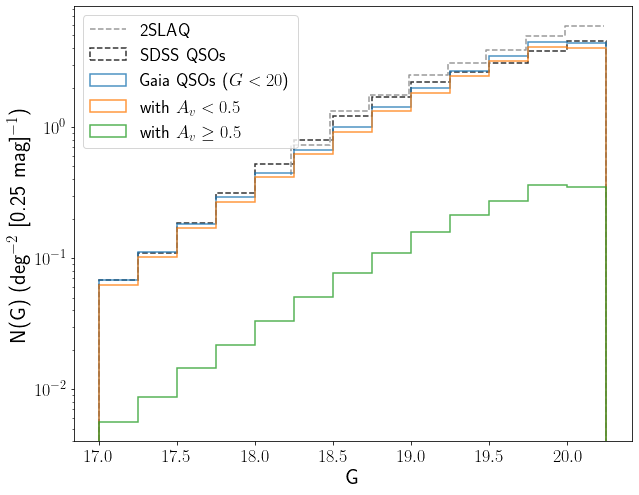

In [109]:
alpha=0.8
lw=1.5
histtype='step'
plt.figure(figsize=(10,8))
idx_mag_in_bins = (mags_2slaq < np.max(mag_bins)) & (mags_2slaq > np.min(mag_bins))
plt.step(mags_2slaq[idx_mag_in_bins], counts_2slaq[idx_mag_in_bins], alpha=alpha, 
         label='2SLAQ', color='grey', where='pre', ls='--')
plt.hist(g_sdss, bins=mag_bins, weights=weights_sdss, alpha=alpha, histtype=histtype, color='k',
         label=r'SDSS QSOs', lw=lw, ls='--')
plt.hist(g_gaia_photoz, bins=mag_bins, weights=weights, alpha=alpha, histtype=histtype, 
         label=r'Gaia QSOs ($G<20$)', lw=lw)
plt.hist(g_gaia_photoz[idx_lowext], bins=mag_bins, weights=weights[idx_lowext], alpha=alpha, histtype=histtype, 
         label=rf'with $A_v < {av_max}$', lw=lw)
plt.hist(g_gaia_photoz[idx_highext], bins=mag_bins, weights=weights[idx_highext], alpha=alpha, histtype=histtype, 
         label=rf'with $A_v \ge {av_max}$', lw=lw)
plt.xlabel('G')
plt.ylabel(r'N(G) (deg$^{-2}$ [0.25 mag]$^{-1}$)')

plt.yscale('log')
plt.legend(loc='upper left')